# Computer Vision Tutorial

## Convolutional Neural Networks

---

CIFAR-10데이터셋에 대해 CNN을 이용한 이미지 분류(classification)를 수행합니다.

In [1]:
# 필요한 기본 라이브러리 import
import random
import torch
import numpy as np
import os
import pandas as pd

## 랜덤시드 고정하기
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
train = pd.read_csv("/kaggle/input/2023-1-w3p1/train.csv")
test = pd.read_csv("/kaggle/input/2023-1-w3p1/test.csv")
sample = pd.read_csv("/kaggle/input/2023-1-w3p1/sample.csv")

print(train.head())

     0    1    2    3    4    5    6    7    8    9  ...  3063  3064  3065  \
0   59   62   63   43   46   45   50   48   43   68  ...   216   184   140   
1  154  177  187  126  137  136  105  104   95  102  ...   143   133   139   
2  255  255  255  253  253  253  253  253  253  253  ...    78    85    83   
3   28   25   10   37   34   19   38   35   20   42  ...    54    47    28   
4  170  180  198  168  178  196  177  185  203  183  ...    75    79    82   

   3066  3067  3068  3069  3070  3071  label  
0   151   118    84   123    92    72      6  
1   143   134   142   143   133   144      9  
2    79    85    83    80    86    84      9  
3    63    56    37    72    65    46      4  
4    71    75    78    73    77    80      1  

[5 rows x 3073 columns]


In [3]:
print('train : ', train.shape)
print('test : ', test.shape)

train :  (50000, 3073)
test :  (10000, 3072)


In [8]:
# x_train, y_train 구분
x_train = train.iloc[:,:-1].to_numpy().reshape(-1,32,32,3)
y_train = train.iloc[:,-1].to_numpy()

x_test = test.to_numpy().reshape(-1,32,32,3)

print('x_train : ', x_train.shape)
print('y_train : ', y_train.shape)
print('x_test : ', x_test.shape)

x_train :  (50000, 32, 32, 3)
y_train :  (50000,)
x_test :  (10000, 32, 32, 3)


In [9]:
# rescale [0,255] -> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [10]:
# 주의 사항 1
# keras와 다르게 torch.nn.CrossEntropyLoss는 자체적으로 one-hot encoding이 내장
# 별도의 one-hot encoding 작업 없이 진행
# 주의 사항 2
# pytorch는 모델에 입력하는 데이터가 tensor 형태로 변경해 주는 작업이 필요
# 또한, pytorch는 keras와 다르게 (Channel, Height, Width)의 형태로 변경해주어야함.

# train, validation set으로 분할
x_train, x_valid = x_train[5000:], x_train[:5000]
y_train, y_valid = y_train[5000:], y_train[:5000]

# 모델에 입력하기 위해 데이터를 tensor 형태로 변경
x_train, y_train = torch.FloatTensor(x_train), torch.LongTensor(y_train)
x_valid, y_valid = torch.FloatTensor(x_valid), torch.LongTensor(y_valid)
x_test = torch.FloatTensor(x_test)

# pytorch는 (Channel, Height, Width)의 형태로 이루어짐
x_train = torch.swapaxes(x_train,1,3)
x_valid = torch.swapaxes(x_valid,1,3)
x_test = torch.swapaxes(x_test,1,3)

print('x_train :', x_train.shape)

x_train : torch.Size([45000, 3, 32, 32])


In [13]:
print('train sample : ', x_train.shape[0])
print('test sample : ', x_test.shape[0])
print('validation sample : ', x_valid.shape[0])

train sample :  45000
test sample :  10000
validation sample :  5000


In [14]:
%pip install torchsummary # model을 요약하기 위해 torchsummary 설치
from torchsummary import summary as summary_# 모델 정보를 확인하기 위해 torchsummary 함수 import

# 모델의 형태를 출력하기 위한 함수 
def summary_model(model,input_shape=(3, 32, 32)):
    model = model.cuda()
    summary_(model, input_shape) # (model, (input shape))

Note: you may need to restart the kernel to use updated packages.


In [29]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=2, padding='same')
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2, padding='same')    
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2, padding='same')
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flat = nn.Flatten()
        
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.4)
        
        self.fc1 = nn.Linear(1024, 500)
        self.fc2 = nn.Linear(500, 10)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        y = self.relu(self.conv1(x))
        y = self.pool(y)
        y = self.relu(self.conv2(y))
        y = self.pool(y)
        y = self.relu(self.conv3(y))
        y = self.pool(y)
        y = self.drop1(y)
        y = self.flat(y)
        y = self.relu(self.fc1(y))
        y = self.drop2(y)
        y = self.softmax(self.fc2(y))
        
        return y

model = Model().cuda()

summary_model(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             208
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           2,080
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]           8,256
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
          Dropout-10             [-1, 64, 4, 4]               0
          Flatten-11                 [-1, 1024]               0
           Linear-12                  [-1, 500]         512,500
             ReLU-13                  [-1, 500]               0
          Dropout-14                  [

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [30]:
train_dataset = torch.utils.data.TensorDataset(x_train,y_train)
valid_dataset = torch.utils.data.TensorDataset(x_valid,y_valid)

# train, test 데이터셋의 로더
# 배치사이즈를 불러오는 데이터를 섞을지 결정할 수 있다.
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
validloader =torch.utils.data.DataLoader(valid_dataset,batch_size=1,shuffle=False)

In [31]:
model = Model().cuda()
learning_rate = 0.001

optimizer = torch.optim.RMSprop(model.parameters(),lr=learning_rate) # RMSprop을 최적화 함수로 이용. 파라미터는 documentation을 참조!
loss = torch.nn.CrossEntropyLoss().cuda() # 분류 문제이므로 CrossEntropyLoss를 이용

In [32]:
# train the model
import time

# 파라미터 설정
total_epoch = 35
best_loss = 100

train_loss_list = []
valid_loss_list = []

for epoch in range(total_epoch):
    start = time.time()
    print(f'Epoch {epoch}/{total_epoch}')

    # train
    model.train()
    train_loss = 0
    for x, target in trainloader: # 한번에 배치사이즈만큼 데이터를 불러와 모델을 학습함
        optimizer.zero_grad() # 이전 loss를 누적하지 않기 위해 0으로 설정해주는 과정
        y_pred = model(x.cuda()) # 모델의 출력값
        cost = loss(y_pred, target.cuda()) # loss 함수를 이용하여 오차를 계산함
    
        cost.backward() # gradient 구하기
        optimizer.step() # 모델 학습
        train_loss += cost.item()
        
    train_loss /= len(trainloader)
    train_loss_list.append(train_loss)
    
    # eval (validation 데이터를 이용하여 모델을 검증)
    eval_loss = 0
    with torch.no_grad(): # 학습하지 않기 위해
        model.eval() # 평가 모드로 변경
        for x, target in validloader:
            y_pred = model(x.cuda()) # 모델의 출력값
            cost = loss(y_pred,target.cuda()) # loss 함수를 이용하여 test 데이터의 오차를 계산함
            eval_loss += cost.item()
            
        eval_loss /= len(validloader)
        valid_loss_list.append(eval_loss)
        
        # validation 데이터의 loss를 기준으로 이전 loss 보다 작을 경우 체크포인트 저장
        if eval_loss < best_loss:
            torch.save({
                'model': model,
                'model_state_dict': model.state_dict()
                }, './bestCheckPoint.pth')            
            best_loss = eval_loss
        
    print(f' - {int(time.time() - start)}s - train_loss: {train_loss:.5f} - eval_loss: {eval_loss:.5f}')

Epoch 0/35


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 - 12s - train_loss: 2.11861 - eval_loss: 2.07804
Epoch 1/35
 - 12s - train_loss: 2.03951 - eval_loss: 2.01180
Epoch 2/35
 - 12s - train_loss: 2.00092 - eval_loss: 1.97510
Epoch 3/35
 - 12s - train_loss: 1.97138 - eval_loss: 1.98598
Epoch 4/35
 - 12s - train_loss: 1.95296 - eval_loss: 1.90890
Epoch 5/35
 - 12s - train_loss: 1.93774 - eval_loss: 1.93176
Epoch 6/35
 - 12s - train_loss: 1.92432 - eval_loss: 1.92296
Epoch 7/35
 - 12s - train_loss: 1.91384 - eval_loss: 1.89362
Epoch 8/35
 - 12s - train_loss: 1.90934 - eval_loss: 1.87730
Epoch 9/35
 - 12s - train_loss: 1.89539 - eval_loss: 1.86350
Epoch 10/35
 - 12s - train_loss: 1.88991 - eval_loss: 1.87062
Epoch 11/35
 - 12s - train_loss: 1.88102 - eval_loss: 1.85828
Epoch 12/35
 - 12s - train_loss: 1.87639 - eval_loss: 1.87797
Epoch 13/35
 - 12s - train_loss: 1.87159 - eval_loss: 1.85305
Epoch 14/35
 - 12s - train_loss: 1.86456 - eval_loss: 1.84022
Epoch 15/35
 - 12s - train_loss: 1.86111 - eval_loss: 1.84482
Epoch 16/35
 - 12s - train_lo

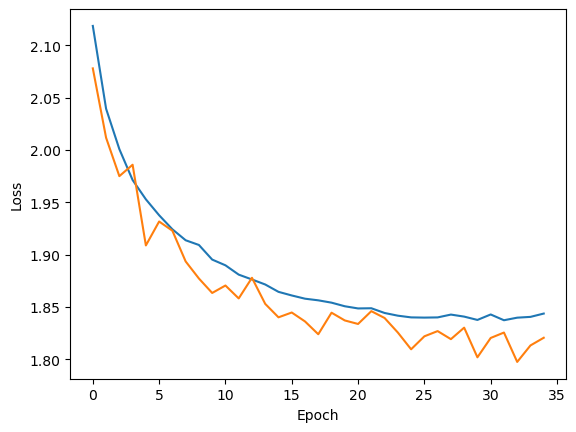

In [33]:
import matplotlib.pyplot as plt

# visualize
plt.figure()
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [34]:
# 저장되어있는 best 체크포인트 load하기
best_model = torch.load('./bestCheckPoint.pth')['model'] # 전체 모델을 통째로 불러옴, 클래스 선언 필수
best_model.load_state_dict(torch.load('./bestCheckPoint.pth')['model_state_dict']) # state_dict를 불러 온 후, 모델에 저장

<All keys matched successfully>

In [35]:
# calculate classification accuracy on test set
with torch.no_grad():
    best_model.eval()
    y_pred = best_model(x_test.cuda())
    pred = y_pred.argmax(dim=1).cpu().numpy()
    
print(pred)

[5 1 8 ... 5 1 7]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [36]:
sample['label'] = pred
sample.to_csv("baseline.csv",index=False)